In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
import sys
import os

print(os.getcwd()+'\\..\\..\\src')
sys.path.append(os.getcwd()+'\\..\\..\\src')

C:\Users\User\master_IASA\MTOI\mtci-iasa\notebooks\genetic\..\..\src


In [3]:
from models import MLP
from utils import CustomDataset
from trainers import GeneticTrainer
from optimizers.genetic import GeneticOptimizer
from config.train_config import GeneticConfig
from torch.nn.functional import mse_loss as mse

In [4]:
import pandas as pd

data = pd.read_csv("../../data/turbines_train.csv")
data = data.drop(["Unnamed: 0", "Time"], axis=1)

In [5]:
data.head(5)

,Location,Temp_2m,RelHum_2m,DP_2m,WS_10m,WS_100m,WD_10m,WD_100m,WG_10m,Power
0,1,28.2796,84.664205,24.072595,1.605389,1.267799,145.051683,161.057315,1.336515,0.163496
1,1,28.1796,85.664205,24.272595,2.225389,3.997799,150.051683,157.057315,4.336515,0.142396
2,1,26.5796,90.664205,24.072595,1.465389,2.787799,147.051683,149.057315,3.136515,0.121396
3,1,27.1796,87.664205,23.872595,1.465389,2.697799,57.051683,104.057315,1.536515,0.100296
4,1,27.0796,87.664205,23.672595,2.635389,4.437799,57.051683,83.057315,3.936515,0.079296


In [6]:
data_x = data.iloc[:, :-1].to_numpy()
data_y = data.iloc[:, -1].to_numpy()
print(f"features shape: {data_x.shape}, target shape: {data_y.shape}")

features shape: (140160, 9), target shape: (140160,)


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
        data_x,
        data_y,
        test_size=0.2,
        random_state=42,
        shuffle=True
    )

In [8]:
import numpy as np

y_train = np.expand_dims(y_train, axis=1)
y_test = np.expand_dims(y_test, axis=1)

In [9]:
train_dataset = CustomDataset(X_train, y_train)
eval_dataset = CustomDataset(X_test, y_test)

In [10]:
model = MLP(X_train.shape[1])
optimizer = GeneticOptimizer(
    population_size=200, 
    tournament_size=6,
    crossover_rate=0.9,
    mutation_rate=0.01,
    model=model,
    loss_fn=mse
)
trainer = GeneticTrainer(
    model=model,
    loss=mse,
    optimizer=optimizer,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    config=GeneticConfig(),
)

In [20]:
best_model = trainer.train(verbose=False)

Training: 100%|██████████| 500/500 [15:39<00:00,  1.88s/it]


In [21]:
best_model.eval()
train_predictions = best_model(train_dataset.features)
eval_predictions = best_model(eval_dataset.features)

MSE = 0.087607786


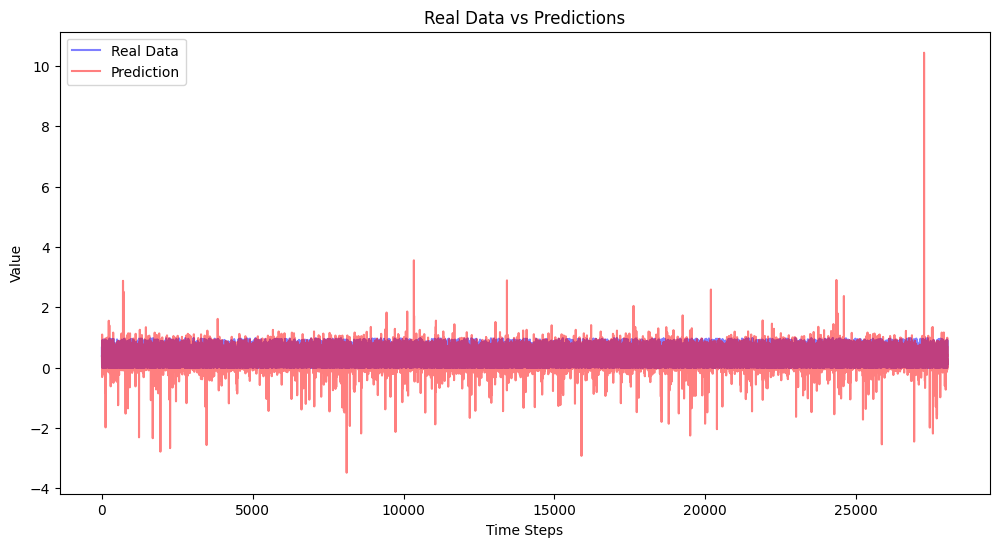

In [22]:
import matplotlib.pyplot as plt

def plot_predictions(real_data, predictions):
    plt.figure(figsize=(12, 6))

    plt.plot(range(len(predictions)), real_data[:, 0], label='Real Data', color='blue', alpha=0.5)
    plt.plot(range(len(predictions)), predictions[:, 0], label='Prediction', color='red', alpha=0.5)

    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.title('Real Data vs Predictions')
    plt.legend()
    plt.show()
    
print("MSE = " + str(mse(eval_dataset.labels, eval_predictions).detach().numpy()))
plot_predictions(eval_dataset.labels.detach().numpy(), eval_predictions.detach().numpy())

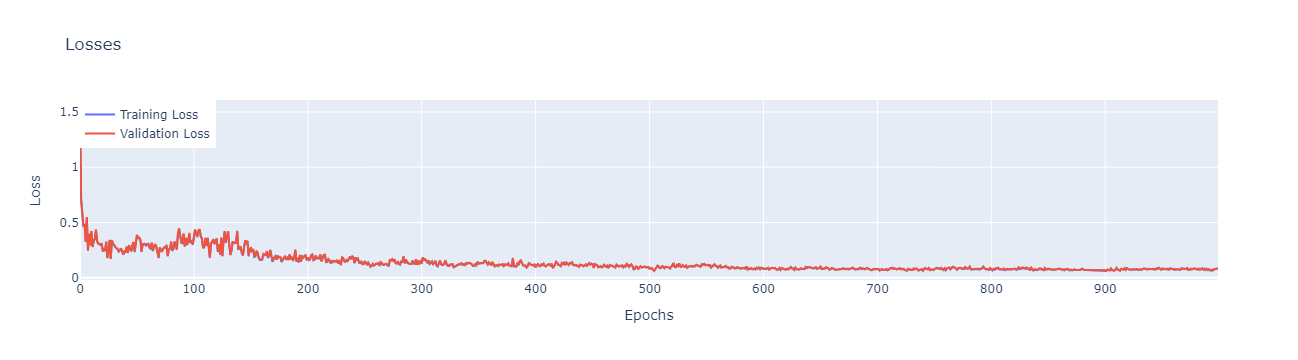

In [23]:
trainer.plot_losses()

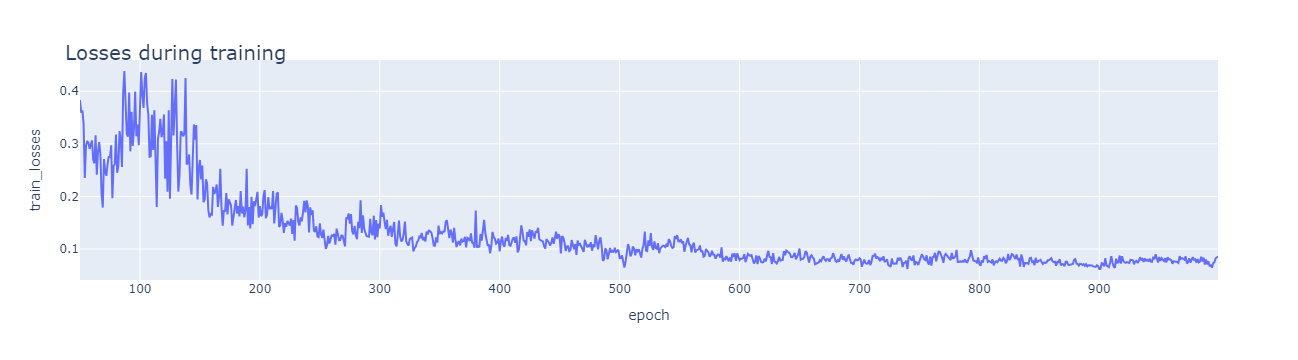

In [30]:
import plotly.express as px

df = pd.DataFrame({
    'train_losses': trainer.train_losses[50:],
    'epoch': range(50, len(trainer.train_losses))})
fig = px.line(df, x='epoch', y='train_losses')
fig.update_layout(title=dict(text="Losses during training", font=dict(size=20), automargin=True, yref='paper'))
fig.show()

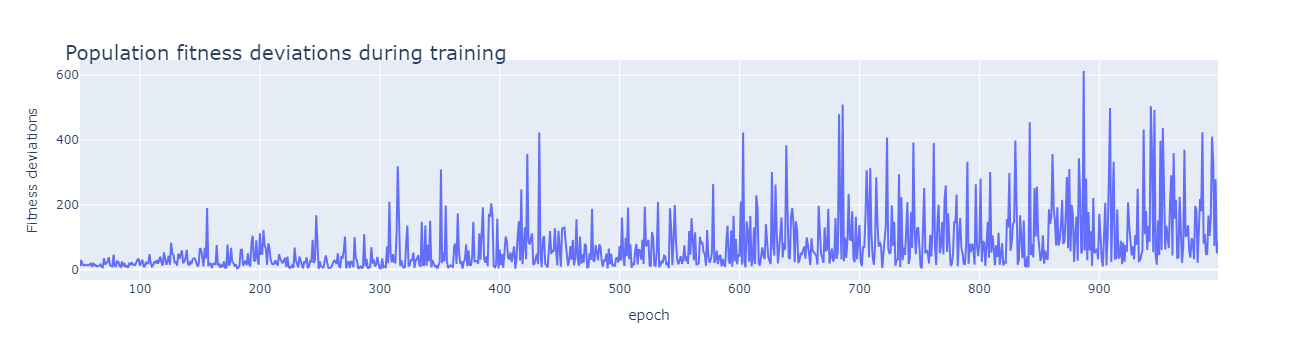

In [31]:
import plotly.express as px

df = pd.DataFrame({
    'Fitness deviations': trainer.population_fitness_deviations[50:],
    'epoch': range(50, len(trainer.population_fitness_deviations))})
fig = px.line(df, x='epoch', y='Fitness deviations')
fig.update_layout(title=dict(text="Population fitness deviations during training", font=dict(size=20), automargin=True, yref='paper'))
fig.show()

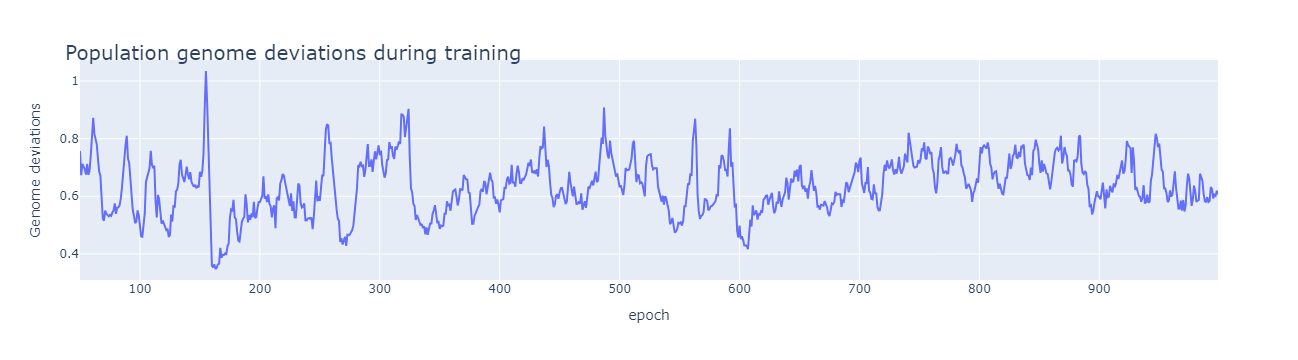

In [32]:
df = pd.DataFrame({
    'Genome deviations': trainer.population_genome_deviations[50:],
    'epoch': range(50, len(trainer.population_fitness_deviations))})
fig = px.line(df, x='epoch', y='Genome deviations')
fig.update_layout(title=dict(text="Population genome deviations during training", font=dict(size=20), automargin=True, yref='paper'))
fig.show()

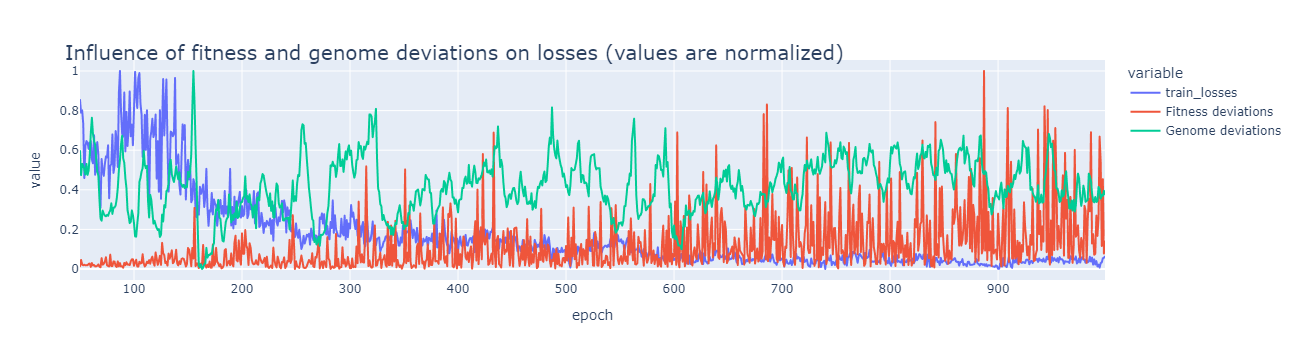

In [28]:
import plotly.express as px

def norm(data):
    min_val = min(data)
    max_val = max(data)
    return [(x - min_val) / (max_val - min_val) for x in data]


df = pd.DataFrame({
    'train_losses': norm(trainer.train_losses[50:]),
    'Genome deviations': norm(trainer.population_genome_deviations[50:]),
    'Fitness deviations': norm(trainer.population_fitness_deviations[50:]),
    'epoch': range(50, len(trainer.population_fitness_deviations))})
fig = px.line(df, x='epoch', y=['train_losses', 'Fitness deviations', 'Genome deviations'])
fig.update_layout(title=dict(text="Influence of fitness and genome deviations on losses (values are normalized)", font=dict(size=20), automargin=True, yref='paper'))
fig.show()

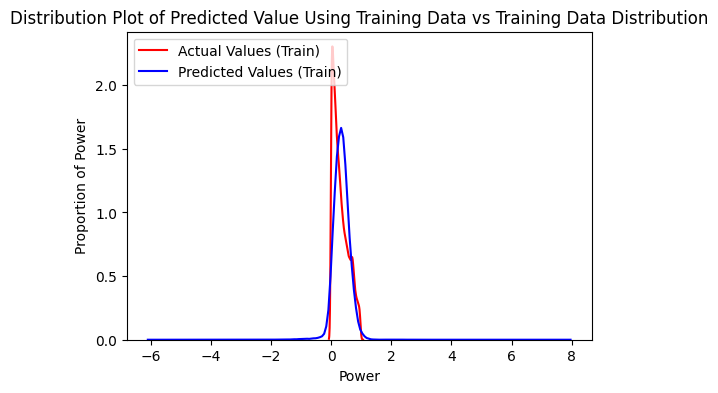

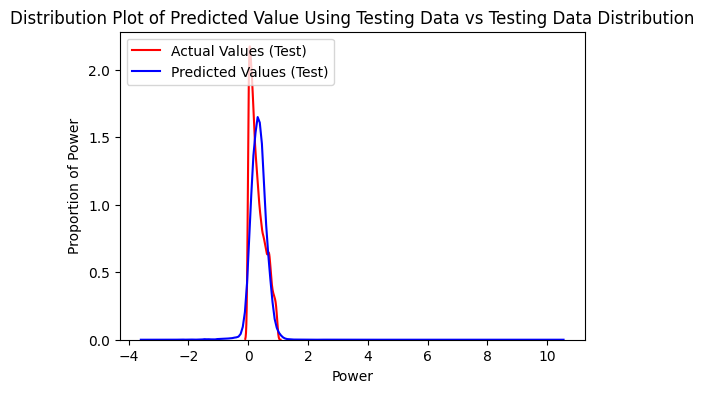

In [33]:
import seaborn as sns

def DistributionPlot(RedFunction, BlueFunction, RedName, BlueName, Title):
  width = 6
  height = 4
  plt.figure(figsize=(width, height))
  ax1 = sns.distplot(RedFunction, hist=False, color="r", label=RedName)
  ax2 = sns.distplot(BlueFunction, hist=False, color="b", label=BlueName, ax=ax1)
  
  plt.title(Title)
  plt.xlabel("Power")
  plt.ylabel("Proportion of Power")

  plt.legend(loc='upper left')
  plt.show()
  plt.close()


DistributionPlot(train_dataset.labels.detach().numpy(), train_predictions.detach().numpy(), "Actual Values (Train)", "Predicted Values (Train)", 
                 "Distribution Plot of Predicted Value Using Training Data vs Training Data Distribution")
DistributionPlot(eval_dataset.labels.detach().numpy(), eval_predictions.detach().numpy(), "Actual Values (Test)", "Predicted Values (Test)", 
                 "Distribution Plot of Predicted Value Using Testing Data vs Testing Data Distribution")